In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [41]:
learning_rate=0.001
train_size=0.9
seqlen=3
bs=32
epochs=200

这些是模型的超参数。
- learning_rate 是学习率，控制模型收敛的快慢，太大了模型容易发散，太小了模型收敛很慢；
- train_size 训练集占整个数据集的比例，一般是28开；
- seqlen：序列长度，在时序建模中，就是用前几个样本来预测当前样本；
- bs：batch size，批量大小，随机梯度下降算法SGD中，每次用来估计梯度的训练样本数量；
考虑到数据集本身只有100多个样本，批量不用太大；
- epochs：训练的轮数，即迭代次数；

In [42]:
df=pd.read_csv('问题2-训练数据-归一化.csv',index_col='time')

In [43]:
df_train, df_val = train_test_split(df, train_size=train_size, shuffle=False)

将数据集分割为训练集和验证集，二者没有交集，训练集用来训练模型，验证集用来确保模型没有过拟合。

In [44]:
feature_size=df_train.shape[1]
df_train.shape, df_val.shape

((110, 6), (13, 6))

In [51]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    df_train.values, df_train.values, sequence_length=seqlen, batch_size=bs, shuffle=True)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    df_val.values, df_val.values, sequence_length=seqlen, batch_size=bs, shuffle=True)

利用keras的接口构造时序模型需要的时序数据集。

In [52]:
dataset_train, dataset_val

(<BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>)

构建一个单层的LSTM模型。LSTM是一种专门用来建模时序数据的神经网络模型，即长短期记忆（Long Short Term Memory）。
可以展开说说理论。

In [53]:
inputs = keras.layers.Input(shape=(seqlen, feature_size))
lstm_out = keras.layers.LSTM(32)(inputs)
# lstm_out = keras.layers.Dropout(0.1)(lstm_out)
outputs = keras.layers.Dense(feature_size)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 6)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                4992      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 5,190
Trainable params: 5,190
Non-trainable params: 0
_________________________________________________________________


训练模型：
1. 使用的损失函数：MSE，Mean Square Error，即均方误差；
2. 早停止：当验证误差经过一段时间不再改进之后，停止训练模型，这是一种停止训练循环的策略；
3. 检查点：当验证误差出现改进时，保存当前的模型参数；

In [54]:
path_checkpoint = "problem2_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/200
1/4 [======>.......................] - ETA: 8s - loss: 0.1851
Epoch 1: val_loss improved from inf to 0.39470, saving model to problem2_checkpoint.h5
4/4 [==============================] - 3s 187ms/step - loss: 0.1623 - val_loss: 0.3947
Epoch 2/200
1/4 [======>.......................] - ETA: 0s - loss: 0.1275
Epoch 2: val_loss improved from 0.39470 to 0.34322, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 41ms/step - loss: 0.1370 - val_loss: 0.3432
Epoch 3/200
1/4 [======>.......................] - ETA: 0s - loss: 0.1128
Epoch 3: val_loss improved from 0.34322 to 0.29518, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 35ms/step - loss: 0.1155 - val_loss: 0.2952
Epoch 4/200
1/4 [======>.......................] - ETA: 0s - loss: 0.1211
Epoch 4: val_loss improved from 0.29518 to 0.25098, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 30ms/step - loss: 0.0962 - val_loss: 0.2510

4/4 [==============================] - 0s 35ms/step - loss: 0.0153 - val_loss: 0.0294
Epoch 34/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0140
Epoch 34: val_loss improved from 0.02943 to 0.02881, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 28ms/step - loss: 0.0149 - val_loss: 0.0288
Epoch 35/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0133
Epoch 35: val_loss improved from 0.02881 to 0.02837, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 36ms/step - loss: 0.0146 - val_loss: 0.0284
Epoch 36/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0134
Epoch 36: val_loss improved from 0.02837 to 0.02828, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 34ms/step - loss: 0.0142 - val_loss: 0.0283
Epoch 37/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0113
Epoch 37: val_loss improved from 0.02828 to 0.02773, saving model to problem2_ch

4/4 [==============================] - 0s 35ms/step - loss: 0.0081 - val_loss: 0.0217
Epoch 69/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0077
Epoch 69: val_loss improved from 0.02174 to 0.02156, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 34ms/step - loss: 0.0080 - val_loss: 0.0216
Epoch 70/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0075
Epoch 70: val_loss improved from 0.02156 to 0.02153, saving model to problem2_checkpoint.h5
4/4 [==============================] - 0s 30ms/step - loss: 0.0078 - val_loss: 0.0215
Epoch 71/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0065
Epoch 71: val_loss did not improve from 0.02153
4/4 [==============================] - 0s 22ms/step - loss: 0.0077 - val_loss: 0.0215
Epoch 72/200
1/4 [======>.......................] - ETA: 0s - loss: 0.0087
Epoch 72: val_loss improved from 0.02153 to 0.02115, saving model to problem2_checkpoint.h5
4/4 [===========================

对模型训练过程的损失函数和验证损失函数进行可视化。
- 基于matplotlib的可视化；
- 基于plotly的可视化；

挑一个好看的就行。

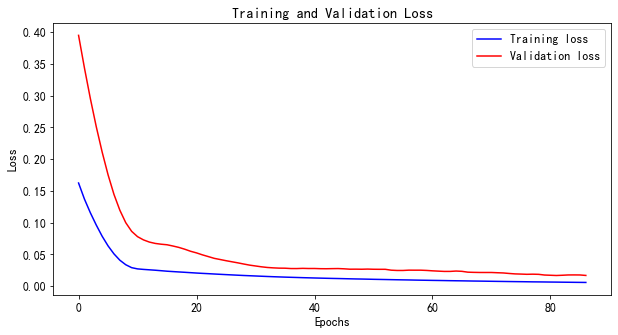

In [55]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [56]:
def visualize_loss_px(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    df=pd.DataFrame(data={'Training loss': loss, 'Validation loss': val_loss})
    return px.line(df, y=df.columns).update_layout(xaxis_title='Epochs', yaxis_title='Loss',legend_title='',title=title)

visualize_loss_px(history, "Training and Validation Loss")